<a href="https://colab.research.google.com/github/dilia-w/Visao-Computacional/blob/main/atividade_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##01 - Calibração de Câmera Monoscópicas

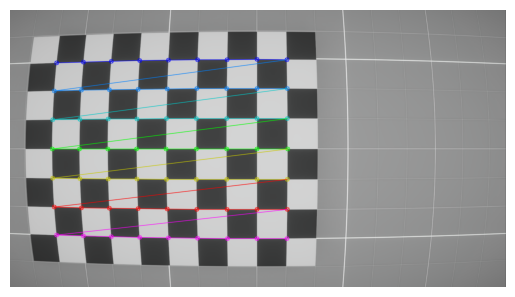

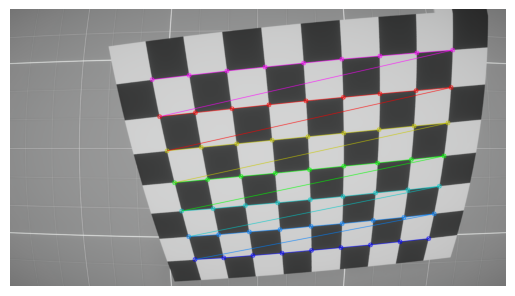

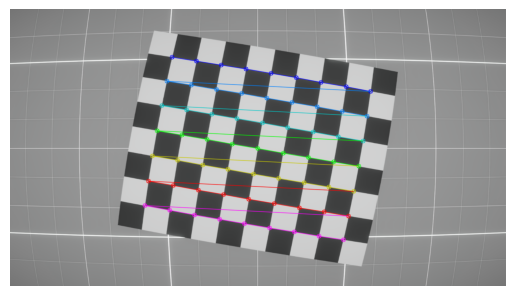

[[653.66999865   0.         620.19130417]
 [  0.         649.44391121 356.05992195]
 [  0.           0.           1.        ]]


In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((9*7, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:7].T.reshape(-1, 2)
objpoints = []
imgpoints = []
imagens = glob.glob('*.png')
for fname in imagens:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 7), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        img = cv2.drawChessboardCorners(img, (9, 7), corners2, ret)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)

##02 - Correção de Imagens

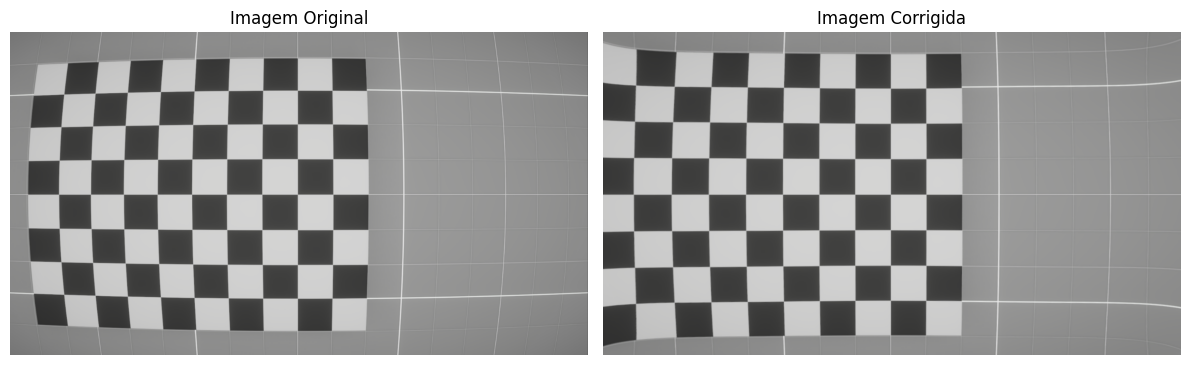

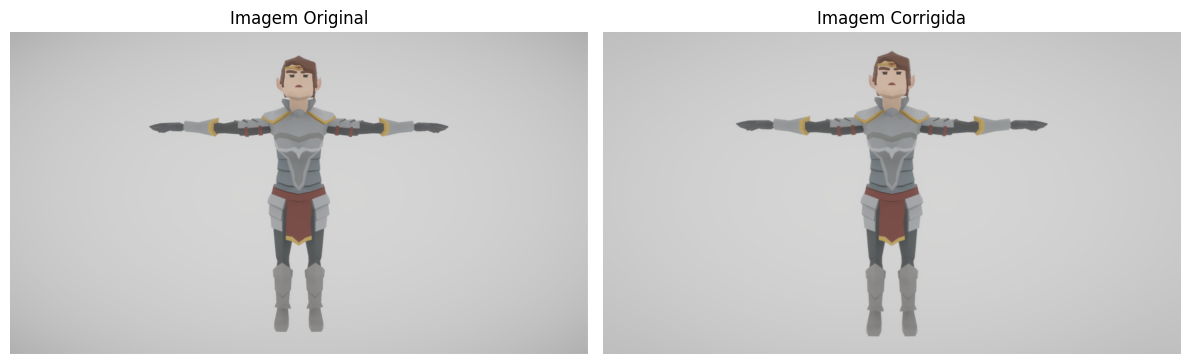

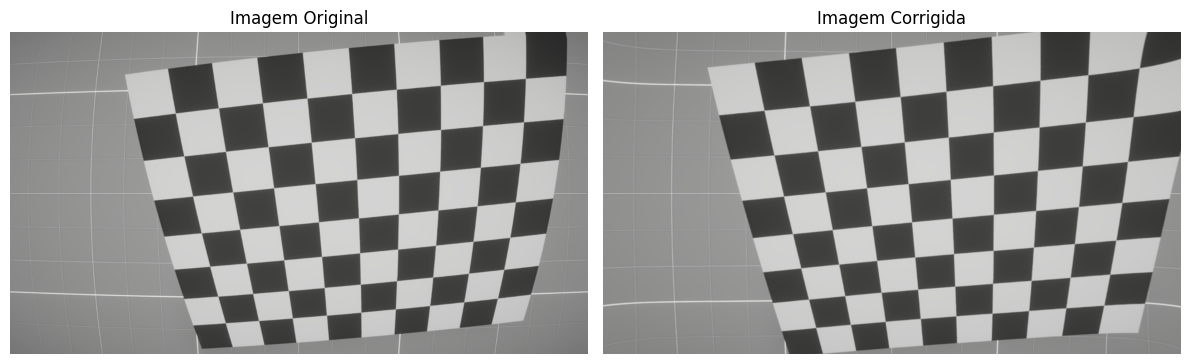

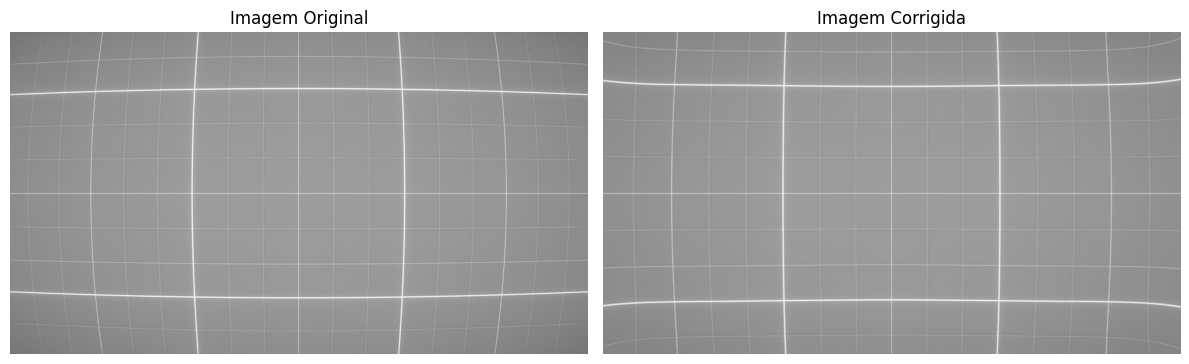

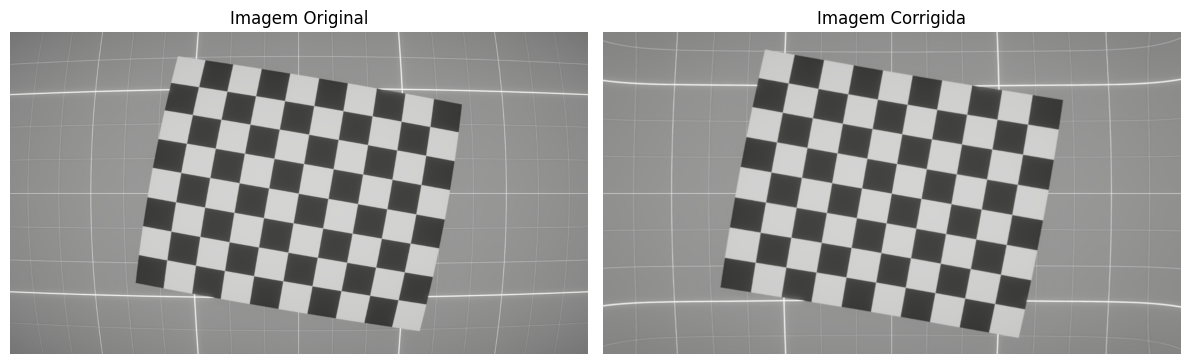

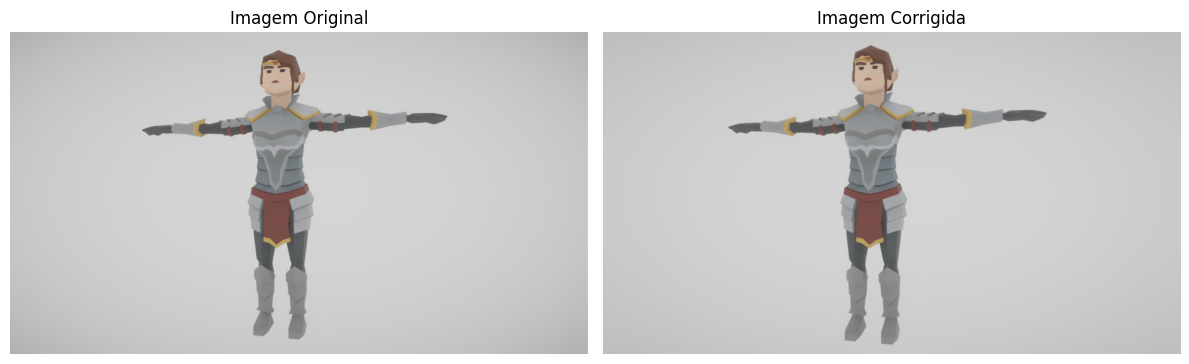

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

imagens = glob.glob('*.png')

for imagem in imagens:
    img = cv2.imread(imagem)
    imagem_corrigida = cv2.undistort(img, mtx, dist, None, mtx)

    # Mostrar a imagem original e a imagem corrigida lado a lado para comparação
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Imagem Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(imagem_corrigida, cv2.COLOR_BGR2RGB))
    plt.title("Imagem Corrigida")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


##03 - Calibração de Câmeras Estereoscópicas

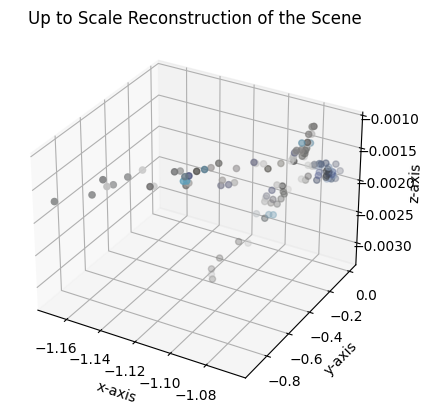

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Suponhamos que I1 e I2 sejam as suas imagens carregadas e intrinsics a matriz intrínseca da câmera
I1 = cv2.imread('Heroi01.png')
I2 = cv2.imread('Heroi02.png')

# Convertendo para tons de cinza
grayI1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
grayI2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# Detectando pontos de características
detector = cv2.GFTTDetector_create(maxCorners=1000, qualityLevel=0.1, minDistance=7)
kp1 = detector.detect(grayI1)
points1 = np.array([kp.pt for kp in kp1], dtype=np.float32)

# Rastrear os pontos de I1 para I2 usando o fluxo óptico
lk_params = dict(winSize=(21, 21),
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01),
                 maxLevel=5)
points2, st, _ = cv2.calcOpticalFlowPyrLK(grayI1, grayI2, points1, None, **lk_params)

# Filtrar apenas pontos válidos (rastreados com sucesso)
valid = st[:, 0] == 1
points1 = points1[valid]
points2 = points2[valid]

# Estimando a pose relativa
E, mask = cv2.findEssentialMat(points1, points2, mtx)
_, R, t, _ = cv2.recoverPose(E, points1, points2, mtx)

# Obtendo matrizes de projeção da câmera
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = np.hstack((R, t))

# Triangulando pontos
points4D = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
points3D = points4D / points4D[3]
points3D = points3D[:3].T

# Obtendo cores para os pontos 3D
color = I1[points1[:, 1].astype(int), points1[:, 0].astype(int)]

# Visualizando em 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3D[:, 0], points3D[:, 1], points3D[:, 2], c=color/255.0)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.set_title('Up to Scale Reconstruction of the Scene')
plt.show()
